# Workshop Tutorial: Estimators

In this tutorial, we'll cover the first stages of fitting a data set with PHOEBE, using the built-in estimator methods:

- lc_periodogram
- rv_periodogram
- ebai
- lc_geometry
- rv_geometry

These methods are meant to offer a kick-start to optimizing and bypass any significant amount of manual tweaking typically required for the user to get to an approximate solution.

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorials:

* [Solving the Inverse Problem](http://phoebe-project.org/docs/latest/tutorials/solver.ipynb)
* [Advanced: LC Estimators](http://phoebe-project.org/docs/latest/tutorials/LC_estimators.ipynb)
* [Advanced: RV Geometry Estimator](http://phoebe-project.org/docs/latest/tutorials/RV_estimators.ipynb)

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
logger = phoebe.logger('WARNING')
%matplotlib inline

For this tutorial and the upcoming fitting tutorials, we'll use a synthetic data set comprised of one light curve and radial velocity curves of the primary and secondary component. Let's load the data in our bundle and plot them first!

You can find the data files in the workshop github repository, or download them from the following links (just note you may need to adjust the paths below when loading):
* [lc.data](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/lc.data)
* [rv1.data](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/rv1.data)
* [rv2.data](https://github.com/phoebe-project/phoebe2-workshop/raw/2021june/data/synthetic/rv2.data)

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


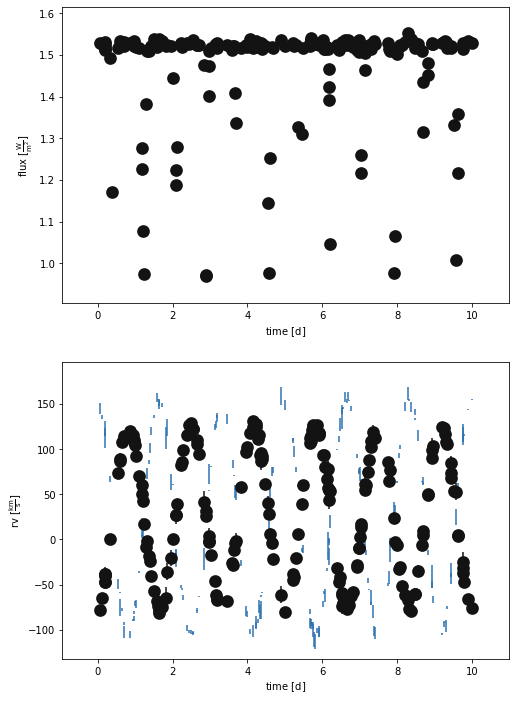

In [3]:
b = phoebe.default_binary(force_build=True)
# lc_tess = np.loadtxt('data/adra/photometry/tess_corrected_new.txt')
lc = np.loadtxt('data/synthetic/lc.data')
rv1 = np.loadtxt('data/synthetic/rv1.data')
rv2 = np.loadtxt('data/synthetic/rv2.data')

b.add_dataset('lc', times = lc[:,0], fluxes=lc[:,1], sigmas=lc[:,2], passband='Johnson:V')
b.add_dataset('rv')
b['times@rv@primary'], b['rvs@rv@primary'], b['sigmas@rv@primary'] = rv1[:,0], rv1[:,1], rv1[:,2]
b['times@rv@secondary'], b['rvs@rv@secondary'], b['sigmas@rv@secondary'] = rv2[:,0], rv2[:,1], rv2[:,2]
_ = b.plot(x='times', show=True)

## Periodograms

PHOEBE offers both light curve and radial velocity curve periodograms. The light curve periodogram supports the box least-squares (BLS) algorithm, which is more suitable for "boxy" eclipses of detached stars, and Lomb-Scargle (LS), which is more suitable for stars with strong ellipsoidal variations. The radial velocity periodogram only supports the LS algorithm.

### rv_periodogram

Let's start with the rv_periodogram first:

In [4]:
b.add_solver('estimator.rv_periodogram', solver='rvperiod')
print(b['rvperiod'])

ParameterSet: 8 parameters
         comments@rvperiod@solver: 
       use_server@rvperiod@solver: none
        algorithm@rvperiod@solver: ls
      rv_datasets@rvperiod@solver: ['*']
        component@rvperiod@solver: binary
      sample_mode@rvperiod@solver: auto
   samples_per_peak@rvperiod@s...: 10
   nyquist_factor@rvperiod@solver: 5


We'll leave all the options to their default values for the time being and see what the output of the solver is.

In [5]:
b.run_solver('rvperiod', solution='rvperiod_solution')
print(b['rvperiod_solution'])

ParameterSet: 10 parameters
R  period@rvperiod_solution@so...: [ 0.40235315  0.41241198  0.42247081
 ... 40.01402079 40.02407961
 40.03413844] d
R  power@rvperiod_solution@sol...: [0.562767   0.55478154 0.55243615 ...
 0.71461299 0.71365716 0.70937088]
   period_factor@rvperiod_solu...: 1.0
R  fitted_twigs@rvperiod_solut...: ['period@binary@orbit@component']
R  fitted_values@rvperiod_solu...: [0.6035297252658087]
R  fitted_units@rvperiod_solut...: ['d']
   adopt_parameters@rvperiod_s...: ['period@binary@orbit@component']
   adopt_distributions@rvperio...: False
   adopt_values@rvperiod_solut...: True
   comments@rvperiod_solution@...: 


The first two lines of the output are the periods and respective powers that the automatic sampling mode has generated. We see that the chosen periods are in the range of 0.4~40, which may not be ideal for our case, where we can roughly estimate from the data that out period is 1-2 days. 

The period_factor can be adjusted by the user and determines if a multiple of the period is to be adopted, since the periodogram may land on a harmonic.

The rest of the output parameters refer to the solution and we can see that the fitted value of ~0.6 is not ideal. So let's instead provide manual samples in a narrower range.

In [6]:
b.set_value('sample_mode', context='solver', solver='rvperiod', value='manual')
b.set_value('sample_periods', context='solver', solver='rvperiod', value=np.linspace(0.5,5,1000))
b.run_solver('rvperiod', solution='rvperiod_solution_2')
print(b['rvperiod_solution_2'])

ParameterSet: 10 parameters
R  period@rvperiod_solution_2@...: [5.         4.9954955  4.99099099 ...
 0.50900901 0.5045045  0.5       ] d
R  power@rvperiod_solution_2@s...: [0.61138889 0.61152714 0.61166504 ...
 0.60717372 0.58970836 0.57461709]
   period_factor@rvperiod_solu...: 1.0
R  fitted_twigs@rvperiod_solut...: ['period@binary@orbit@component']
R  fitted_values@rvperiod_solu...: [1.6711711711711712]
R  fitted_units@rvperiod_solut...: ['d']
   adopt_parameters@rvperiod_s...: ['period@binary@orbit@component']
   adopt_distributions@rvperio...: False
   adopt_values@rvperiod_solut...: True
   comments@rvperiod_solution_...: 


The new value of the period ~1.67 looks much better now! Let's adopt it and plot our data in phase space to see the result.

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


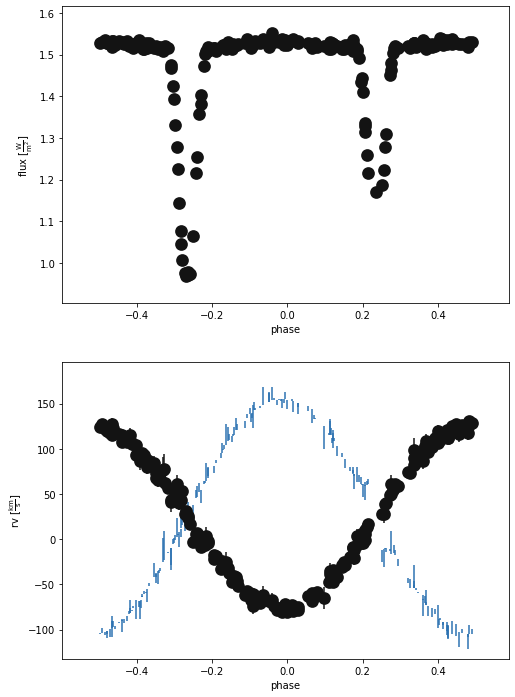

(<autofig.figure.Figure | 2 axes | 3 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [7]:
b.adopt_solution('rvperiod_solution_2')
b.plot(x='phase', show=True)

### lc_periodogram

The light curve periodogram follows a similar workflow as the rv_periodogram. Let's add two different ones and assign one of the two algorithm options to each.

In [8]:
b.add_solver('estimator.lc_periodogram', solver='lcperiod_bls', algorithm='bls')
b.add_solver('estimator.lc_periodogram', solver='lcperiod_ls', algorithm='ls')

<ParameterSet: 13 parameters | qualifiers: component, duration, samples_per_peak, objective, sample_mode, use_server, minimum_n_cycles, lc_combine, sample_periods, lc_datasets, algorithm, comments, nyquist_factor>

Not all parameters are applicable for both algorithms. For more details check: http://phoebe-project.org/docs/2.4/api/phoebe.parameters.solver.estimator.lc_periodogram

In [9]:
b.run_solver('lcperiod_bls', solution='lcperiod_bls_solution', overwrite=True)
print(b['fitted_values@lcperiod_bls_solution'])
b.run_solver('lcperiod_ls', solution='lcperiod_ls_solution', overwrite=True)
print(b['fitted_values@lcperiod_ls_solution'])

Parameter: fitted_values@lcperiod_bls@lcperiod_bls_solution@solution
                       Qualifier: fitted_values
                     Description: final values returned by the minimizer (in current default units of each parameter)
                           Value: [0.8342607178298331]
                  Constrained by: 
                      Constrains: None
                      Related to: None

Parameter: fitted_values@lcperiod_ls@lcperiod_ls_solution@solution
                       Qualifier: fitted_values
                     Description: final values returned by the minimizer (in current default units of each parameter)
                           Value: [1.1970006217771874]
                  Constrained by: 
                      Constrains: None
                      Related to: None



As expected, the bls algorithm performed better in our case, yielding half the period returned from the rv_periodogram. We can easily adopt the correct period by passing the period_factor in .adopt_solution():

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


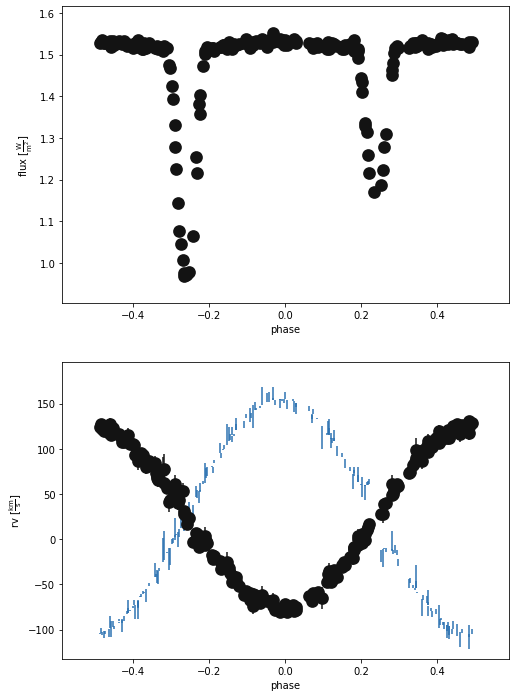

(<autofig.figure.Figure | 2 axes | 3 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [10]:
b.adopt_solution('lcperiod_bls_solution', period_factor=2)
b.plot(x='phase', show=True)

And now we have a period for our system straight from PHOEBE! 

## Parameter estimates from geometry

Before running the solvers, let's flip the required constraints and tweak some of the compute options, so that our computations run faster after adopting the solutions.

In [11]:
# ensures the model light curve is scaled to the data
b.set_value('pblum_mode', 'dataset-scaled')
# speeds up run_compute
b.set_value_all('distortion_method', 'sphere')
# avoids errors from atmospheres
b.set_value_all('atm', 'blackbody')
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_mode_bol', 'manual')

# constraints that needs to be flipped
# for lc_geometry
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('teffratio', solve_for='teff@secondary')

# for rv_geometry
b.flip_constraint('asini@binary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = {asini@binary@component} / (sin({incl@binary@component})) (solar units) => 5.3 solRad>

### rv_geometry

The rv_geometry solver provides simple estimates for several parameters that can be obtained from the radial velocity curves.

In [12]:
b.add_solver('estimator.rv_geometry', solver='rvgeom', overwrite=True)
b.run_solver('rvgeom', solution='rvgeom_solution')

<ParameterSet: 17 parameters | components: secondary, primary>

In [13]:
for param, value, unit in zip(b.get_value('fitted_twigs', solution='rvgeom_solution'),
                       b.get_value('fitted_values', solution='rvgeom_solution'),
                        b.get_value('fitted_units', solution='rvgeom_solution')):
     print('%s = %.2f %s' % (param,value,unit))

t0_supconj@binary@orbit@component = -0.44 d
q@binary@orbit@component = 0.80 
asini@binary@orbit@component = 5571441.07 km
ecc@binary@orbit@component = 0.01 
per0@binary@orbit@component = 3.86 rad
vgamma@system = 25.07 km / s


100%|████████████████████████████████████████| 200/200 [00:05<00:00, 39.64it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


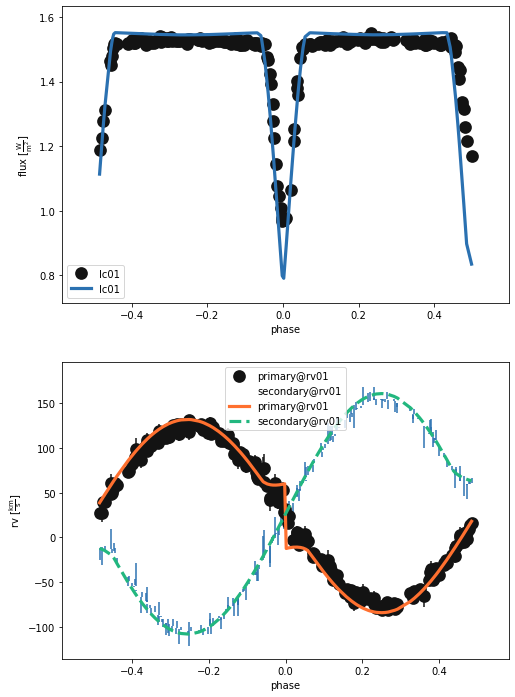

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [14]:
b.adopt_solution('rvgeom_solution')
b.run_compute(model='rvgeom_model')
b.plot(x='phase', legend=True, show=True)

### EBAI

The EBAI (Eclipsing Binaries Aritifical Intelligence) estimator relies on machine learning methods to return estimates of the sum of radii, inclination, temperature ratio, esinw and ecosw from the light curve. There are two methods available in EBAI as of PHOEBE 2.4: 'mlp', which uses a trained neural network, and 'knn', which uses a k-Nearest Neighbors regressor.

Now we're ready to add and run EBAI:

In [15]:
b.add_solver('estimator.ebai', ebai_method='mlp', solver='ebai_mlp_est')
b.run_solver('ebai_mlp_est', solution='ebai_mlp_solution')

<ParameterSet: 13 parameters | qualifiers: input_phases, fitted_values, orbit, ebai_fluxes, comments, ebai_phases, input_sigmas, adopt_values, fitted_twigs, fitted_units, input_fluxes, adopt_parameters, adopt_distributions>

In [16]:
for param, value, unit in zip(b.get_value('fitted_twigs', solution='ebai_mlp_solution'),
                       b.get_value('fitted_values', solution='ebai_mlp_solution'),
                        b.get_value('fitted_units', solution='ebai_mlp_solution')):
     print('%s = %.2f %s' % (param,value,unit))

t0_supconj@binary@orbit@component = -0.44 d
teffratio@binary@orbit@component = 0.82 
requivsumfrac@binary@orbit@component = 0.35 
esinw@binary@orbit@component = 0.02 
ecosw@binary@orbit@component = -0.06 
incl@binary@orbit@component = 1.48 rad


100%|████████████████████████████████████████| 200/200 [00:04<00:00, 41.61it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


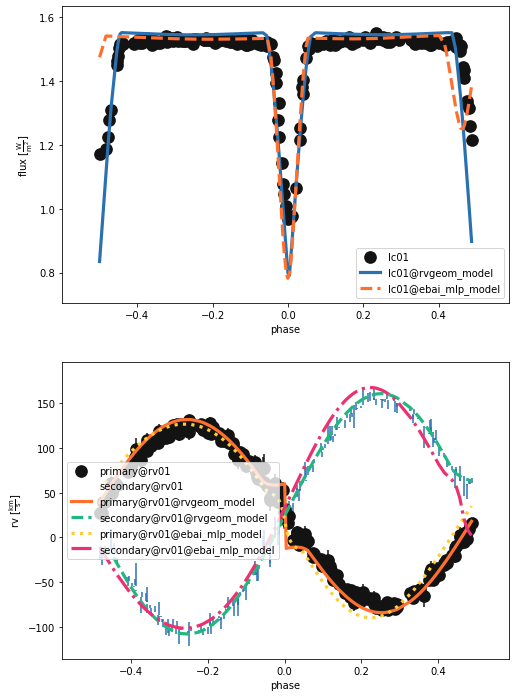

(<autofig.figure.Figure | 2 axes | 9 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [17]:
# flip the esinw/ecosw constraints so we can adopt the solution
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

# adopt solution and compute the model
b.adopt_solution('ebai_mlp_solution')
b.run_compute(model='ebai_mlp_model')
b.plot(x='phase', legend=True, show=True)

We can see that EBAI with the 'mlp' method is not particularly good at estimating esinw and ecosw. Let's try the same with the 'knn' method:

In [18]:
b.add_solver('estimator.ebai', ebai_method='knn', solver='ebai_knn_est')
b.run_solver('ebai_knn_est', solution='ebai_knn_solution')

Thu, 16 Jun 2022 09:04 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Thu, 16 Jun 2022 09:04 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.


<ParameterSet: 13 parameters | qualifiers: input_phases, fitted_values, orbit, ebai_fluxes, comments, ebai_phases, input_sigmas, adopt_values, fitted_twigs, fitted_units, input_fluxes, adopt_parameters, adopt_distributions>

In [19]:
for param, value, unit in zip(b.get_value('fitted_twigs', solution='ebai_knn_solution'),
                       b.get_value('fitted_values', solution='ebai_knn_solution'),
                        b.get_value('fitted_units', solution='ebai_knn_solution')):
     print('%s = %.2f %s' % (param,value,unit))

t0_supconj@binary@orbit@component = -0.44 d
teffratio@binary@orbit@component = 0.83 
requivsumfrac@binary@orbit@component = 0.35 
esinw@binary@orbit@component = 0.04 
ecosw@binary@orbit@component = -0.00 
incl@binary@orbit@component = 1.46 rad


100%|████████████████████████████████████████| 200/200 [00:04<00:00, 40.71it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


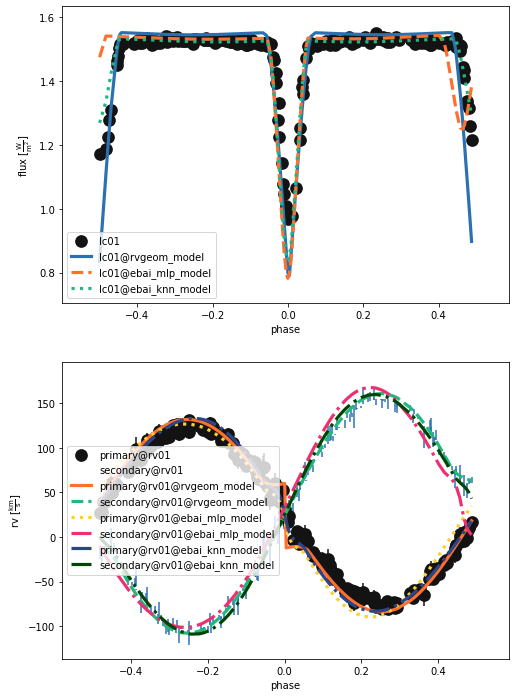

(<autofig.figure.Figure | 2 axes | 12 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [20]:
b.adopt_solution('ebai_knn_solution')
b.run_compute(model='ebai_knn_model')
b.plot(x='phase', legend=True, show=True)

We can see that the 'knn' estimator does a better job at estimating esinw and ecosw! Let's finally compare the results of these two machine learning models with a model based on the light curve geometry (lc_geometry), which estimates all of the parameters that EBAI does, with the exception of inclination:

In [21]:
b.add_solver('estimator.lc_geometry', solver='lcgeom')
b.run_solver('lcgeom', solution='lcgeom_solution')

<ParameterSet: 21 parameters | qualifiers: input_sigmas, primary_width, input_fluxes, fitted_values, orbit, primary_depth, adopt_values, fitted_units, analytic_fluxes, adopt_parameters, comments, primary_phase, input_phases, analytic_best_model, secondary_width, analytic_phases, secondary_phase, secondary_depth, eclipse_edges, fitted_twigs, adopt_distributions>

In [22]:
for param, value, unit in zip(b.get_value('fitted_twigs', solution='lcgeom_solution')[:5],
                       b.get_value('fitted_values', solution='lcgeom_solution')[:5],
                        b.get_value('fitted_units', solution='lcgeom_solution')[:5]):
     print('%s = %.2f %s' % (param,value,unit))

t0_supconj@binary@orbit@component = 1.23 d
ecc@binary@orbit@component = 0.01 
per0@binary@orbit@component = 1.58 rad
requivsumfrac@binary@orbit@component = 0.39 
teffratio@binary@orbit@component = 0.91 


100%|████████████████████████████████████████| 200/200 [00:05<00:00, 37.84it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


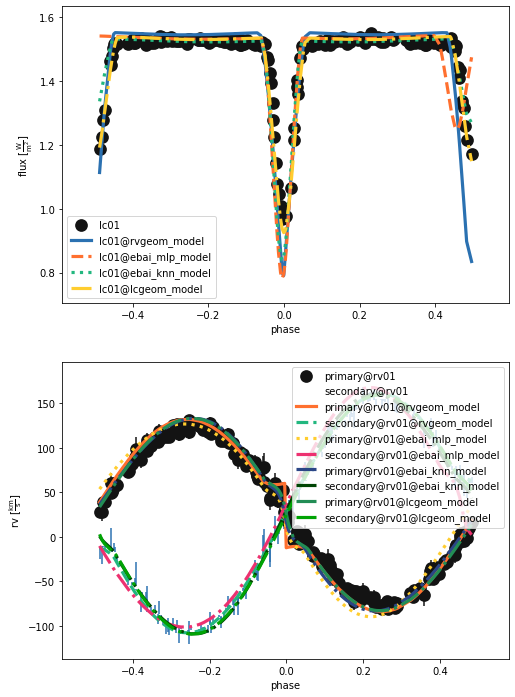

(<autofig.figure.Figure | 2 axes | 15 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [23]:
# lc_geometry returns ecc and per0, so we need to flip the constraints back before adopting the solution
b.flip_constraint('ecc', solve_for='esinw')
b.flip_constraint('per0', solve_for='ecosw')

b.adopt_solution('lcgeom_solution')
b.run_compute(model='lcgeom_model')
b.plot(x='phase', legend=True, show=True)

That looks great! lc_geometry further improved on the eclipse fits and we now have a good starting position for optimizers.

Finally, let's return the atmosphere parameters to their default PHOEBE values and ensure that our solution is within the atmosphere table bounds. (Moving forward to optimiziers and samplers, we want to make sure that we're starting from a somewhat physical solution!)

100%|████████████████████████████████████████| 200/200 [00:05<00:00, 36.89it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


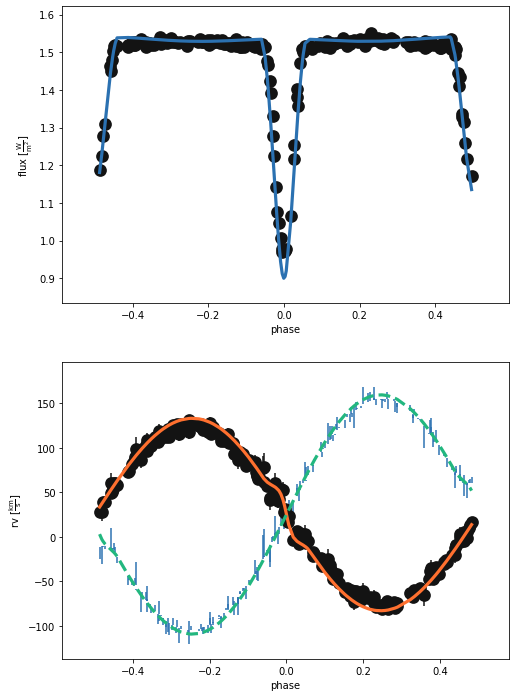

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [24]:
b.set_value_all('atm', 'ck2004')
b.set_value_all('ld_mode', 'interp')
b.set_value_all('ld_mode_bol', 'lookup')
b.run_compute()
b.plot(['dataset', 'latest'], x='phase', show=True)

In [25]:
b.save('data/synthetic/after_estimators.bundle')

'data/synthetic/after_estimators.bundle'

# Exercises

1. Initialize a new bundle and load the synthetic light curve used in the tutorial. Add a light curve periodogram and try to tweak the parameter values, such that the periodogram will yield the true period, instead of the half-value harmonic.

2. Initialize a new bundle. Load only the primary radial velocity data. Set the period to 1.67 and t0 to 1.23. Add an rv_geometry estimatator and examine how the output is different compared to the output in the tutorial, where we had both RVs.

3. (Optional) The lc_geometry estimator offers two analytical models that can be fitted to the light curve to estimate the eclipse parameters (and from that, the parameters of interest). In the same bundle used in the example above, add a new lc_geometry estimator and change the analytical model from 'two-gaussian' to 'polyfit'. Plot the resulting light curves from both and try to determine if one model performs better than the other for this case!